In [ ]:
# ===============================================================ASSIGNMENT_20===========================================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import stats

In [2]:
df = pd.read_csv('20. monthly_milk_production.csv', parse_dates=['Date'], index_col='Date')

In [3]:
print(df.head())

            Production
Date                  
1962-01-01         589
1962-02-01         561
1962-03-01         640
1962-04-01         656
1962-05-01         727


In [ ]:
# --------------------------------------------------------1.Exploratory Data Analysis (EDA)-----------------------------------------------------------

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB
None


In [6]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       Production
count  168.000000
mean   754.708333
std    102.204524
min    553.000000
25%    677.750000
50%    761.000000
75%    824.500000
max    969.000000


In [ ]:
# Check for any missing values or outliers.

In [7]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Production    0
dtype: int64


In [8]:
df = df.interpolate(method='time')

In [ ]:
# Visualize trends, seasonality, and anomalies in the milk production data.

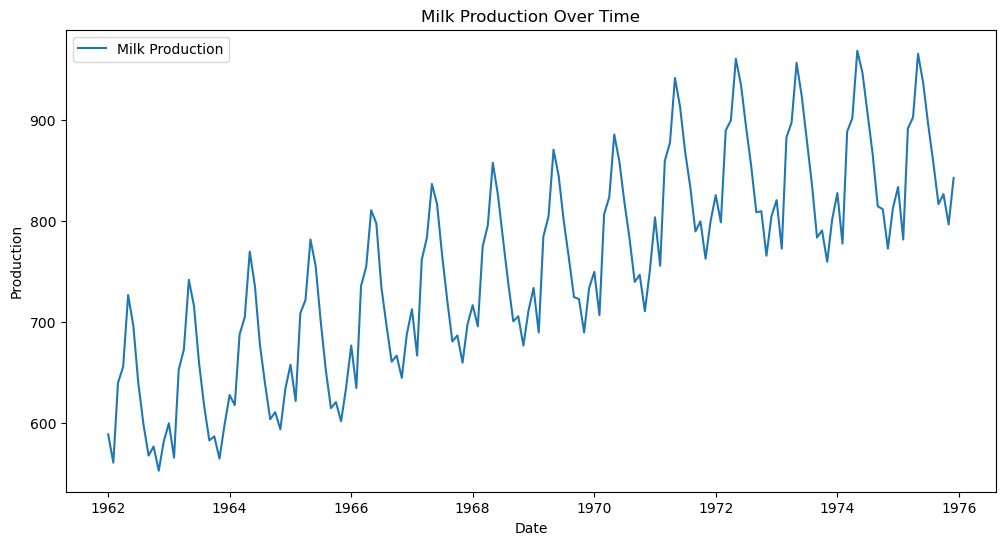

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df, label='Milk Production')
plt.title('Milk Production Over Time')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

In [10]:
rolling_window = 12 
df['Rolling_Mean'] = df['Production'].rolling(window=rolling_window).mean()
df['Rolling_Std'] = df['Production'].rolling(window=rolling_window).std()

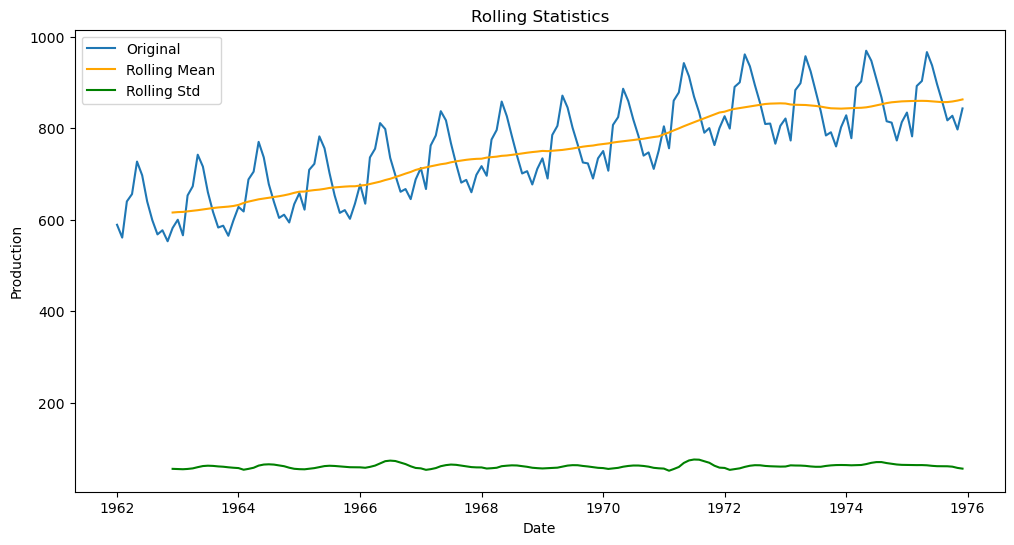

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df['Production'], label='Original')
plt.plot(df['Rolling_Mean'], label='Rolling Mean', color='orange')
plt.plot(df['Rolling_Std'], label='Rolling Std', color='green')
plt.title('Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

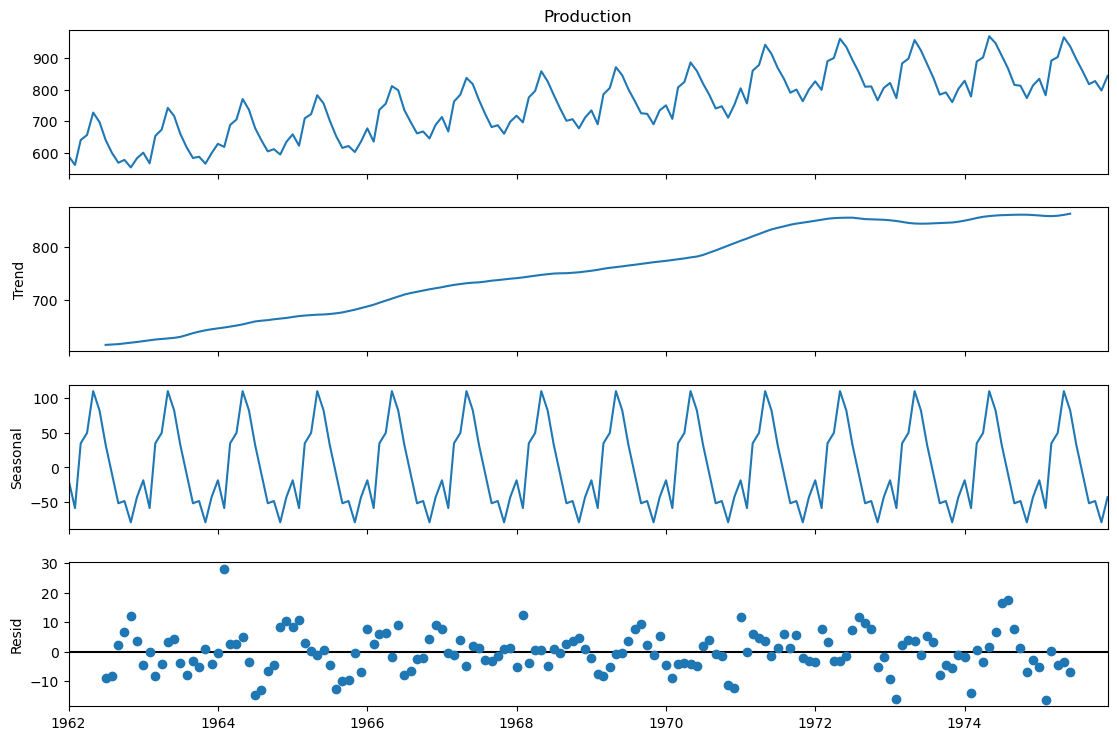

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Production'], model='additive', period=12) 
fig = decomposition.plot()
fig.set_size_inches(12, 8)

In [14]:
z_scores = np.abs(stats.zscore(df['Production']))
outliers = df[z_scores > 3]
print("\nOutliers:")
print(outliers)


Outliers:
Empty DataFrame
Columns: [Production, Rolling_Mean, Rolling_Std]
Index: []


In [ ]:
# o	Normalize or scale the data for neural network models.

In [15]:
scaler = MinMaxScaler()
df['Production_Scaled'] = scaler.fit_transform(df[['Production']])

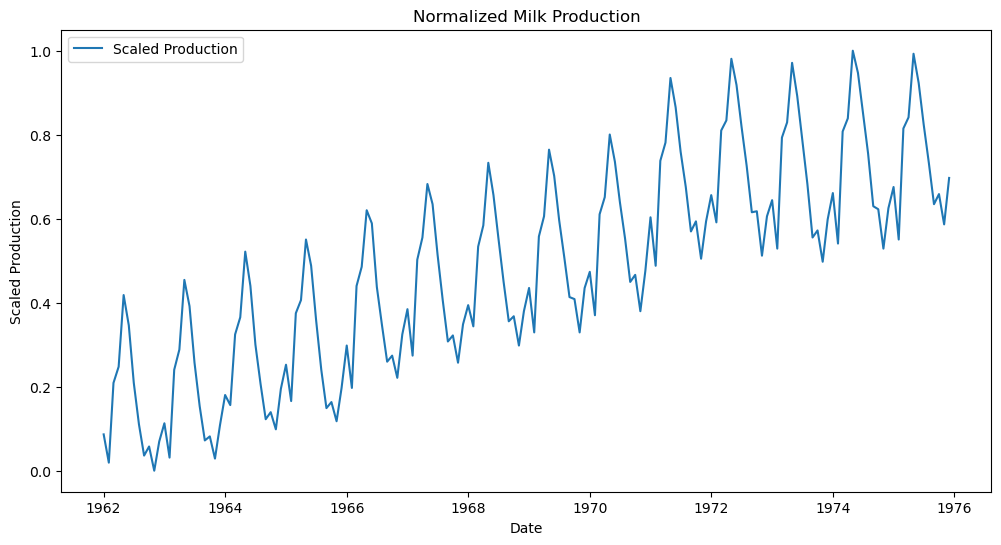

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df['Production_Scaled'], label='Scaled Production')
plt.title('Normalized Milk Production')
plt.xlabel('Date')
plt.ylabel('Scaled Production')
plt.legend()
plt.show()

In [ ]:
# -----------------------------------------------------2.	Data Preparation for Deep Learning--------------------------------------------------------
# o	Create input-output sequences (time windows) suitable for training RNNs/LSTMs/GRUs.

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

In [18]:
data = df['Production_Scaled'].values

In [19]:
def create_sequences(data, window_size):
    """
    Converts time series data into sequences for RNN/LSTM/GRU.
    
    Args:
        data (array): 1D array of time series data.
        window_size (int): Number of past steps to use as input.
    
    Returns:
        X, y arrays
    """
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [20]:
window_size = 12 
X, y = create_sequences(data, window_size)

In [21]:
print("Shape of X:", X.shape)  
print("Shape of y:", y.shape)  

Shape of X: (156, 12)
Shape of y: (156,)


In [ ]:
# o	Split data into training, validation, and test sets.

In [22]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1765, shuffle=False)  

In [23]:
print("\nTraining set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)


Training set shape: (108, 12)
Validation set shape: (24, 12)
Test set shape: (24, 12)


In [ ]:
# o	Reshape data for model input dimensions.

In [24]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("\nReshaped Training set shape:", X_train.shape)  
print("Reshaped Validation set shape:", X_val.shape)
print("Reshaped Test set shape:", X_test.shape)


Reshaped Training set shape: (108, 12, 1)
Reshaped Validation set shape: (24, 12, 1)
Reshaped Test set shape: (24, 12, 1)


In [ ]:
# ------------------------------------------------------------------3.	Model Building-----------------------------------------------------------------

In [ ]:
# Build three separate models:
# . Basic RNN
# . LSTM
# . GRU

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam

In [26]:
window_size = 12      
units = 50            # Number of neurons in RNN/LSTM/GRU layers
batch_size = 16
epochs = 50
learning_rate = 0.001

In [27]:
def build_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(units, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [28]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [29]:
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [30]:
input_shape = (X_train.shape[1], X_train.shape[2])  
rnn_model = build_rnn_model(input_shape)
lstm_model = build_lstm_model(input_shape)
gru_model = build_gru_model(input_shape)

C:\Users\sdsum\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
print("RNN Model Summary:")
rnn_model.summary()

RNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
print("\nLSTM Model Summary:")
lstm_model.summary()


LSTM Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
print("\nGRU Model Summary:")
gru_model.summary()


GRU Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# o	Tune hyperparameters (e.g., window size, number of units, batch size, epochs).

In [34]:
print("Training RNN...")
rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=epochs, batch_size=batch_size, verbose=1)

Training RNN...
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - loss: 0.3524 - val_loss: 0.0230
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0606 - val_loss: 0.0185
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0168 - val_loss: 0.0457
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0142 - val_loss: 0.0302
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0062 - val_loss: 0.0037
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0062 - val_loss: 0.0041
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0040 - val_loss: 0.0100
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0034 - val_loss: 0.0083
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0029 - val_loss: 0.0048
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0027 - val_loss: 0.0049
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0024 - val_loss: 0.0053
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0023 - 

In [35]:
print("Training LSTM...")
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                              epochs=epochs, batch_size=batch_size, verbose=1)

Training LSTM...
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - loss: 0.1397 - val_loss: 0.1698
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0435 - val_loss: 0.0260
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0337 - val_loss: 0.0355
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0289 - val_loss: 0.0316
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0259 - val_loss: 0.0396
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0256 - val_loss: 0.0299
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0240 - val_loss: 0.0250
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0246 - val_loss: 0.0245
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0238 - val_loss: 0.0283
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0236 - val_loss: 0.0267
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0231 - val_loss: 0.0247
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - loss: 0.0228

In [36]:
print("Training GRU...")
gru_history = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=epochs, batch_size=batch_size, verbose=1)

Training GRU...
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - loss: 0.1963 - val_loss: 0.2868
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0669 - val_loss: 0.0910
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0329 - val_loss: 0.0269
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0345 - val_loss: 0.0254
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0294 - val_loss: 0.0371
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0259 - val_loss: 0.0494
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0256 - val_loss: 0.0483
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0245 - val_loss: 0.0421
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0235 - val_loss: 0.0338
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0231 - val_loss: 0.0320
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0224 - val_loss: 0.0320
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0218 - 

In [ ]:
# o	Use appropriate loss functions and optimizers.

In [41]:
# Evaluate RNN
rnn_eval = rnn_model.evaluate(X_test, y_test, verbose=0)
rnn_loss = rnn_eval if isinstance(rnn_eval, float) else rnn_eval[0]
rnn_mae = None if isinstance(rnn_eval, float) else rnn_eval[1]

# Evaluate LSTM
lstm_eval = lstm_model.evaluate(X_test, y_test, verbose=0)
lstm_loss = lstm_eval if isinstance(lstm_eval, float) else lstm_eval[0]
lstm_mae = None if isinstance(lstm_eval, float) else lstm_eval[1]

# Evaluate GRU
gru_eval = gru_model.evaluate(X_test, y_test, verbose=0)
gru_loss = gru_eval if isinstance(gru_eval, float) else gru_eval[0]
gru_mae = None if isinstance(gru_eval, float) else gru_eval[1]

# Print results
print("\nTest Performance:")
print(f"RNN -> Loss: {rnn_loss:.4f}, MAE: {rnn_mae}")
print(f"LSTM -> Loss: {lstm_loss:.4f}, MAE: {lstm_mae}")
print(f"GRU -> Loss: {gru_loss:.4f}, MAE: {gru_mae}")


Test Performance:
RNN -> Loss: 0.1760, MAE: 0.40981733798980713
LSTM -> Loss: 0.5602, MAE: 0.7352545261383057
GRU -> Loss: 0.6955, MAE: 0.8222141265869141


In [ ]:
# --------------------------------------------------------4.	Model Evaluation----------------------------------------------------------------------

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [43]:
rnn_pred = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)
gru_pred = gru_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


In [44]:
rnn_pred_orig = scaler.inverse_transform(rnn_pred)
lstm_pred_orig = scaler.inverse_transform(lstm_pred)
gru_pred_orig = scaler.inverse_transform(gru_pred)
y_test_orig = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
# o	Plot predictions vs. actual values.

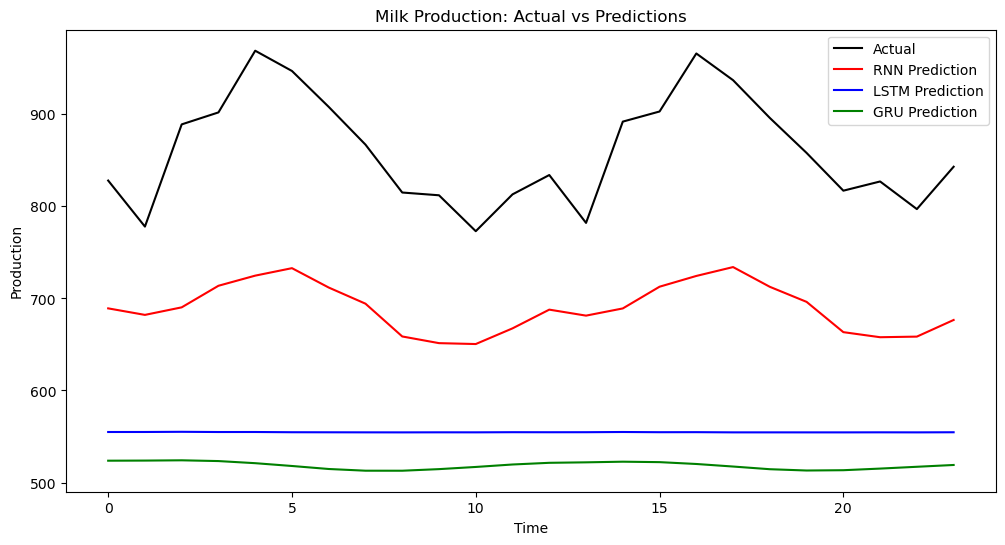

In [45]:
plt.figure(figsize=(12,6))
plt.plot(y_test_orig, label='Actual', color='black')
plt.plot(rnn_pred_orig, label='RNN Prediction', color='red')
plt.plot(lstm_pred_orig, label='LSTM Prediction', color='blue')
plt.plot(gru_pred_orig, label='GRU Prediction', color='green')
plt.title('Milk Production: Actual vs Predictions')
plt.xlabel('Time')
plt.ylabel('Production')
plt.legend()
plt.show()

In [ ]:
# o	Calculate forecasting metrics: RMSE, MAE, MAPE.

In [46]:
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    return rmse, mae, mape

rnn_rmse, rnn_mae, rnn_mape = calculate_metrics(y_test_orig, rnn_pred_orig)
lstm_rmse, lstm_mae, lstm_mape = calculate_metrics(y_test_orig, lstm_pred_orig)
gru_rmse, gru_mae, gru_mape = calculate_metrics(y_test_orig, gru_pred_orig)

In [47]:
print("Model Performance Comparison:")
print(f"{'Model':<10}{'RMSE':<10}{'MAE':<10}{'MAPE (%)':<10}")
print(f"{'RNN':<10}{rnn_rmse:<10.4f}{rnn_mae:<10.4f}{rnn_mape:<10.2f}")
print(f"{'LSTM':<10}{lstm_rmse:<10.4f}{lstm_mae:<10.4f}{lstm_mape:<10.2f}")
print(f"{'GRU':<10}{gru_rmse:<10.4f}{gru_mae:<10.4f}{gru_mape:<10.2f}")

Model Performance Comparison:
Model     RMSE      MAE       MAPE (%)  
RNN       174.5294  170.4840  19.62     
LSTM      311.3635  305.8659  35.25     
GRU       346.9214  342.0411  39.48     


In [ ]:
# o	Compare the performance of RNN, LSTM, and GRU.

In [48]:
# Metrics for each model (assuming predictions and y_test_orig)
metrics = {
    'Model': ['RNN', 'LSTM', 'GRU'],
    'RMSE': [rnn_rmse, lstm_rmse, gru_rmse],
    'MAE': [rnn_mae, lstm_mae, gru_mae],
    'MAPE (%)': [rnn_mape, lstm_mape, gru_mape]
}

import pandas as pd

metrics_df = pd.DataFrame(metrics)
print("Model Performance Comparison:")
print(metrics_df)

Model Performance Comparison:
  Model        RMSE         MAE   MAPE (%)
0   RNN  174.529362  170.484027  19.624392
1  LSTM  311.363521  305.865906  35.251386
2   GRU  346.921363  342.041069  39.476907


In [ ]:
#-------------------------------------------------- 5.	Prediction and Visualization------------------------------------------------------------------

In [ ]:
# o	Forecast milk production for the next 12 months.

In [56]:
forecast_steps = 12
last_sequence = X_test[-1].reshape(1, window_size, 1)  
forecast = []

for _ in range(forecast_steps):
    # Predict next value
    next_value = lstm_model.predict(last_sequence, verbose=0)  
    forecast.append(next_value[0,0])
    
    next_value_reshaped = next_value.reshape(1,1,1)
    
    last_sequence = np.concatenate([last_sequence[:,1:,:], next_value_reshaped], axis=1)

# Inverse scale
forecast_orig = scaler.inverse_transform(np.array(forecast).reshape(-1,1))
print("Next 12 months forecast:\n", forecast_orig)

Next 12 months forecast:
 [[554.6306 ]
 [555.44934]
 [555.46265]
 [555.4463 ]
 [555.3706 ]
 [555.1783 ]
 [554.8852 ]
 [554.5304 ]
 [554.16693]
 [553.8283 ]
 [553.5372 ]
 [553.26245]]


In [ ]:
# o	Visualize the predicted trend with uncertainty or confidence intervals if possible.

C:\Users\sdsum\AppData\Local\Temp\ipykernel_24704\1328206811.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


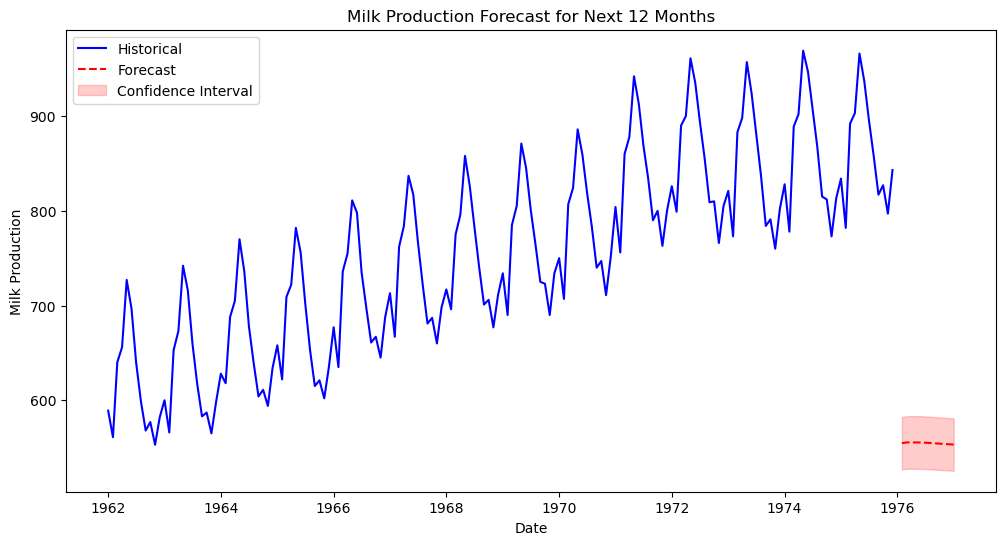

In [59]:
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

plt.figure(figsize=(12,6))

# Historical milk production
plt.plot(df.index, df['Production'].values, label='Historical', color='blue')

# Forecasted production
plt.plot(forecast_index, forecast_orig, label='Forecast', color='red', linestyle='--')

# Simple +-5% confidence interval
plt.fill_between(forecast_index, 
                 forecast_orig.flatten()*0.95, 
                 forecast_orig.flatten()*1.05, 
                 color='red', alpha=0.2, label='Confidence Interval')

plt.title('Milk Production Forecast for Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Milk Production')
plt.legend()
plt.show()

In [ ]:
# ---------------------------------------------------------------6.	Business Insights------------------------------------------------------------------
# o	Interpret results and recommend how the dairy business can use these forecasts for better planning and resource allocation.

In [ ]:
# Business Insights

# Production Planning:
# . Use forecasts to schedule production efficiently, avoid overproduction, and meet demand peaks.
# Resource Allocation:
# . Plan feed, staff, and raw materials based on predicted milk output to reduce costs and waste.
# Storage & Distribution:
# .  Adjust cold storage and supply chain logistics according to expected production.
# Financial Planning:
# . Estimate revenue fluctuations, optimize budgets, and prepare for low-production months.
# Risk Management:
# . Use confidence intervals to maintain buffer stock and mitigate shortages.

# Conclusion: Forecasting helps the dairy business optimize operations, reduce waste, improve efficiency, and increase profitability.